In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
import seaborn as sns
from numba import jit, njit, float64
from numba.experimental import jitclass
from ing_theme_matplotlib import mpl_style
from math import sqrt

mpl_style(True)

In [2]:
# auxiliary functions

@njit
def solve_price_up_equation(P_ext, X, Y, fee, N):
    def equation(y_eq):
        lhs = (Y + 2 * N * y_eq) / X
        rhs = np.sqrt(
            P_ext * (1 - fee) / (1 + fee) * (Y + 2 * (N - 1) * y_eq) / X
        )
        return lhs - rhs

    def derivative(y_eq):
        lhs = 2 * N / X
        rhs = (P_ext * (1 - fee) / (1 + fee) * 2 * (N - 1) / X) / (
            2 * np.sqrt(P_ext * (1 - fee) / (1 + fee) * (Y + 2 * (N - 1) * y_eq) / X)
        )
        return lhs - rhs

    initial_guess = 0
    tolerance = 1e-8
    max_iterations = 1024

    y_eq = initial_guess

    for _ in range(max_iterations):
        y_eq_new = y_eq - equation(y_eq) / derivative(y_eq)

        if np.abs(equation(y_eq_new)) < tolerance:
            return y_eq_new

        y_eq = y_eq_new

    raise RuntimeError("Newton-Raphson did not converge for y_eq")

In [3]:
# Example usage: Scenario that the price went up
X = 1000
Y = 1000 * 2500
N = 10
fee = 0.0015
P_up = 2500 * (1 + fee) / (1 - fee) * (1 + 1e-6)

y_eq_solution = solve_price_up_equation(P_up, X, Y, fee, N)
print("y_eq =", y_eq_solution)

y_eq = 0.11363638166339303


In [4]:
# Example usage: Scenario that the price went down
X = 1000
Y = 1000 * 2500
N = 10
fee = 0.0015
P_up = 2500 * (1 - fee) / (1 + fee) * (1 - 1e-6)

y_eq_solution = solve_price_up_equation(1/P_up, Y, X, fee, N)
print("x_eq =", y_eq_solution)

x_eq = 4.5454598131247624e-05


In [5]:
########################################
#              CPMM class              #
########################################

CPMM_spec = [("X", float64), ("Y", float64), ("fee", float64), ("trade_count", float64)]


@jitclass(CPMM_spec)
class CPMM:
    """
    This is standard Uniswap V2-style CPMM.
    Fee is charged on input side.
    """

    def __init__(self, p, l, fee):
        self.X = l / sqrt(p)
        self.Y = l * sqrt(p)
        self.fee = fee
        self.trade_count = 0.0

    def price(self):
        """
        spot price of pool
        """
        return self.Y / self.X

    def liquidity(self):
        """
        liquidity of pool
        """
        return sqrt(self.X * self.Y)

    def trade(self, P_ext, c):
        """
        P_ext: external price
        c: tx cost
        """
        new_X = self.X
        new_Y = self.Y

        # price is high enough
        if P_ext * (1 - self.fee) > self.price():
            P_rep = P_ext * (1 - self.fee)
            new_X = self.liquidity() / sqrt(P_rep)
            new_Y = self.Y + (self.liquidity() * sqrt(P_rep) - self.Y) / (1 - self.fee)

        # price is low enough
        elif P_ext < self.price() * (1 - self.fee):
            P_rep = P_ext / (1 - self.fee)
            new_Y = self.liquidity() * sqrt(P_rep)
            new_X = self.X + (self.liquidity() / sqrt(P_rep) - self.X) / (1 - self.fee)

        # price is within non-trading range
        else:
            return 0

        # calculate the change in reserves
        delta_X = new_X - self.X
        delta_Y = new_Y - self.Y

        # calculate the arbitrager's profit
        profit = -(P_ext * delta_X + delta_Y) - c

        if profit > 0:
            # update the state
            self.X = new_X
            self.Y = new_Y
            self.trade_count += 1

            # return the AMM loss
            return P_ext * delta_X + delta_Y
        else:
            return 0

In [6]:
########################################
#              FMAMM class             #
########################################

FMAMM_spec = [
    ("X", float64),
    ("Y", float64),
    ("fee", float64),
    ("trade_count", float64),
]


@jitclass(FMAMM_spec)
class FMAMM:
    """
    This is FM-AMM based on constant product invariant.
    Fee is charged on both side to keep the price constant even after adding fee.
    """

    def __init__(self, p, l, fee):
        self.X = l / sqrt(p)
        self.Y = l * sqrt(p)
        self.fee = fee
        self.trade_count = 0.0

    def price(self):
        return self.Y / self.X

    def liquidity(self):
        return sqrt(self.X * self.Y)

    def trade(self, P_ext, c):
        """
        P_ext: external price
        c: tx cost
        """
        new_X = self.X
        new_Y = self.Y

        # temporary variables
        N = 0
        x_eq = 0
        y_eq = 0
        profit = 0

        # price is high enough
        if P_ext * (1 - self.fee) / (1 + self.fee) > self.price():
            for i in range(
                1, 11
            ):  # There may be more arbitrageurs, but we limit the number by 10 here.
                # find y_eq
                y_eq = solve_price_up_equation(P_ext, self.X, self.Y, self.fee, i)
                P_c = (self.Y + 2 * i * y_eq) / self.X

                # calculate arbitrageur's profit
                temp_profit = (
                    -(1 + self.fee) * y_eq  # sell to the pool
                    + (1 - self.fee) * P_ext * y_eq / P_c  # buy from the pool
                    - c  # tx cost
                )

                # if profitable, update N and proceed
                if temp_profit > 0:
                    N = i
                    profit = temp_profit
                    new_Y = self.Y + N * y_eq * (1 + self.fee)
                    new_X = self.X - N * y_eq / P_c * (1 - self.fee)
                else:
                    break

        # price is low enough
        elif P_ext * (1 + self.fee) / (1 - self.fee) < self.price():
            for i in range(
                1, 11
            ):  # There may be more arbitrageurs, but we limit the number by 10 here.
                # find x_eq; we just flip the variables and use same function
                x_eq = solve_price_up_equation(1 / P_ext, self.Y, self.X, self.fee, i)
                P_c = self.Y / (self.X + 2 * i * x_eq)

                # calculate arbitrageur's profit
                temp_profit = (
                    -(1 + self.fee) * x_eq * P_ext  # sell to the pool
                    + (1 - self.fee) * x_eq * P_c  # buy from the pool
                    - c  # tx cost
                )

                # if profitable, update N and proceed
                if temp_profit > 0:
                    N = i
                    profit = temp_profit
                    new_X = self.X + N * x_eq * (1 + self.fee)
                    new_Y = self.Y - N * x_eq * P_c * (1 - self.fee)
                else:
                    break

        # price is within non-trading range
        else:
            return 0

        # calculate the change in reserves
        delta_X = new_X - self.X
        delta_Y = new_Y - self.Y

        # calculate the AMM loss
        if profit > 0:
            # update the state
            self.X = new_X
            self.Y = new_Y
            self.trade_count += 1

            return P_ext * delta_X + delta_Y
        else:
            return 0

In [7]:
@njit
def run_simulations(p_init, l_init, tx_cost, daily_std, blocks_per_day, paths, days=1):
    # LVR for CPMM, FMAMM
    results = np.zeros((4, paths))

    for j in range(paths):
        # initialize the pools
        cpmm = CPMM(p_init, l_init, 0.003)
        fmamm = FMAMM(p_init, l_init, 0.0015)

        # save the initial price
        p0 = cpmm.price()

        sigma = daily_std / np.sqrt(blocks_per_day)  # vol between blocks
        T = int(days * blocks_per_day)

        # Generate a GBM path for prices
        z = np.cumsum(np.random.normal(0.0, sigma, T))
        # Note that we are adding a risk-neutral drift, so that the price process is a martingale
        prices = np.exp(z - (np.arange(T) * sigma**2) / 2)
        prices = prices / prices[0] * p0

        lvr_cpmm = 0
        lvr_fmamm = 0

        for i in range(T):
            # CPMM
            val_cpmm = prices[i] * cpmm.X + cpmm.Y
            lvr_cpmm += -cpmm.trade(prices[i], tx_cost) / val_cpmm

            # FMAMM
            val_fmamm = prices[i] * fmamm.X + fmamm.Y
            lvr_fmamm += -fmamm.trade(prices[i], tx_cost) / val_fmamm

        results[:, j] = [
            lvr_cpmm / days,
            lvr_fmamm / days,
            prices[T - 1] * cpmm.X + cpmm.Y,
            prices[T - 1] * fmamm.X + fmamm.Y,
        ]

    return results

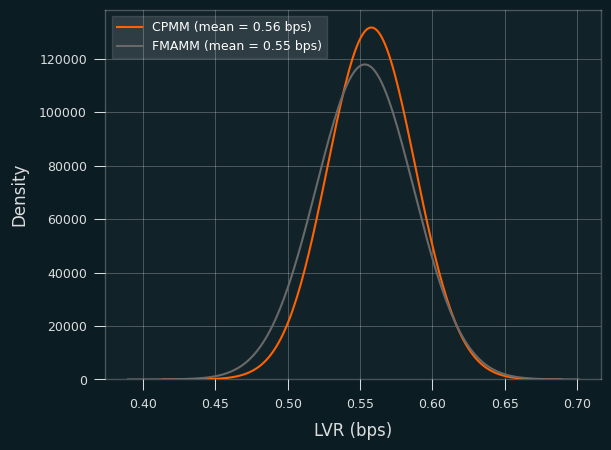

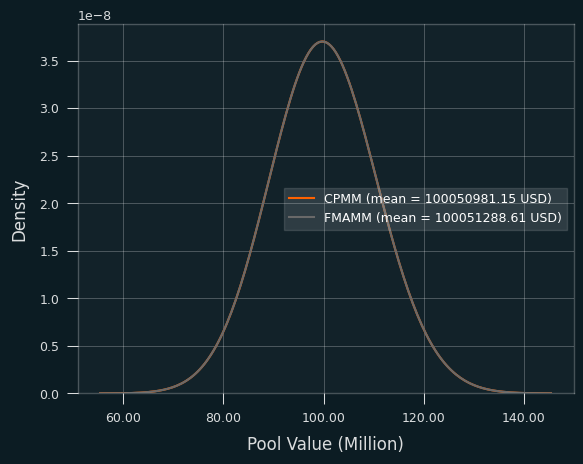

In [8]:
# Scenario 1: 5% daily volatility, L1
p_init = 2_500.0
l_init = 1_000_000.0
tx_cost = 10

daily_std = 0.05
block_time = 12  # 12 for Mainnet, 5 for Gnosis, 2 for L2s
blocks_per_day = 24 * 60 * 60 / block_time
paths = 1_000
days = 7

results = run_simulations(
    p_init, l_init, tx_cost, daily_std, blocks_per_day, paths, days
)

bw_adjust = 5
means = np.mean(results, 1)

ax = sns.kdeplot(
    data=results[0, :],
    bw_adjust=bw_adjust,
    label=f"CPMM (mean = {means[0] * 10**4:.2f} bps)",
)
ax = sns.kdeplot(
    data=results[1, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM (mean = {means[1] * 10**4:.2f} bps)",
)

ax.set(xlabel="LVR (bps)", ylabel="Density")
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels([f"{tick * 10000:.2f}" for tick in ticks_loc])

plt.legend()
plt.show()

ax = sns.kdeplot(
    data=results[2, :],
    bw_adjust=bw_adjust,
    label=f"CPMM (mean = {means[2]:.2f} USD)",
)
ax = sns.kdeplot(
    data=results[3, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM (mean = {means[3]:.2f} USD)",
)

ax.set(xlabel="Pool Value (Million)", ylabel="Density")
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels([f"{tick / 10**6:.2f}" for tick in ticks_loc])

plt.legend()
plt.show()

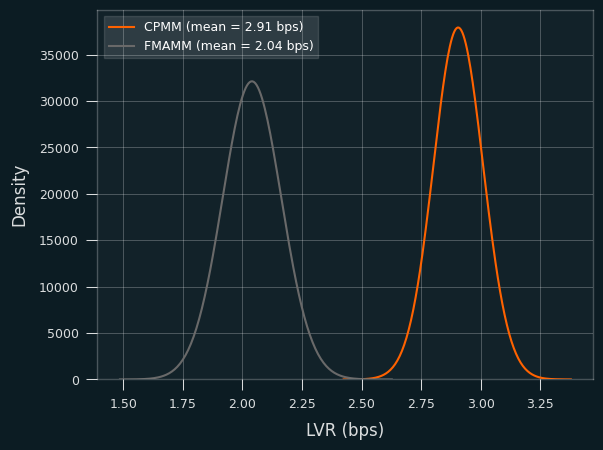

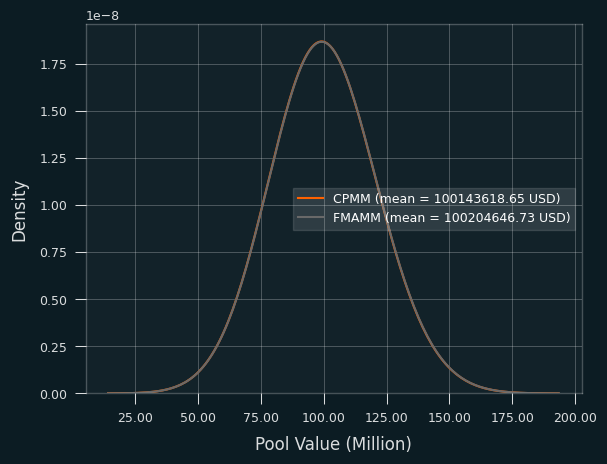

In [9]:
# Scenario 2: 10% daily volatility, L1
p_init = 2_500.0
l_init = 1_000_000.0
tx_cost = 10

daily_std = 0.1
block_time = 12  # 12 for Mainnet, 5 for Gnosis, 2 for L2s
blocks_per_day = 24 * 60 * 60 / block_time
paths = 1_000
days = 7

results = run_simulations(
    p_init, l_init, tx_cost, daily_std, blocks_per_day, paths, days
)

bw_adjust = 5
means = np.mean(results, 1)

ax = sns.kdeplot(
    data=results[0, :],
    bw_adjust=bw_adjust,
    label=f"CPMM (mean = {means[0] * 10**4:.2f} bps)",
)
ax = sns.kdeplot(
    data=results[1, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM (mean = {means[1] * 10**4:.2f} bps)",
)

ax.set(xlabel="LVR (bps)", ylabel="Density")
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels([f"{tick * 10000:.2f}" for tick in ticks_loc])

plt.legend()
plt.show()

ax = sns.kdeplot(
    data=results[2, :],
    bw_adjust=bw_adjust,
    label=f"CPMM (mean = {means[2]:.2f} USD)",
)
ax = sns.kdeplot(
    data=results[3, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM (mean = {means[3]:.2f} USD)",
)

ax.set(xlabel="Pool Value (Million)", ylabel="Density")
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels([f"{tick / 10**6:.2f}" for tick in ticks_loc])

plt.legend()
plt.show()

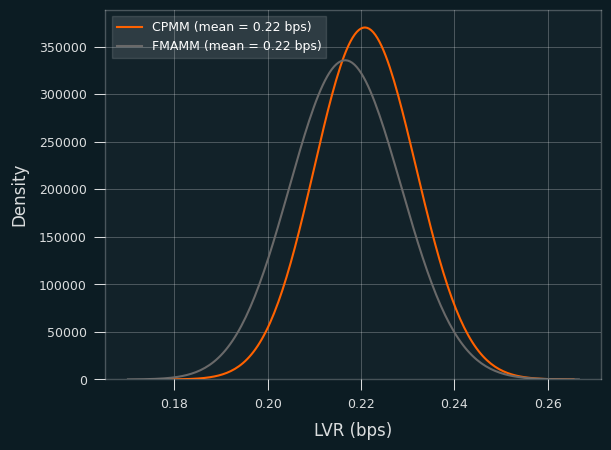

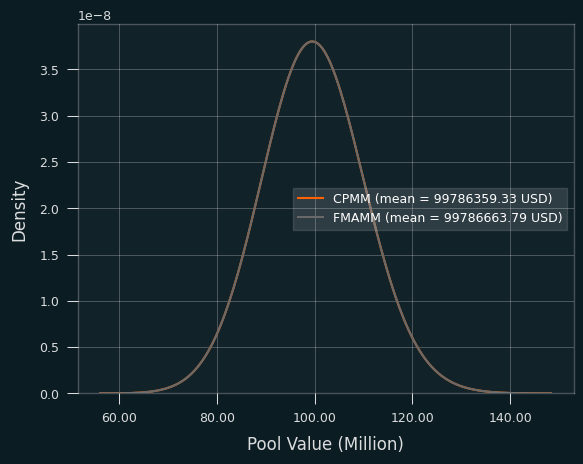

In [10]:
# Scenario 3: 5% daily volatility, L2
p_init = 2_500.0
l_init = 1_000_000.0
tx_cost = 1

daily_std = 0.05
block_time = 2  # 12 for Mainnet, 5 for Gnosis, 2 for L2s
blocks_per_day = 24 * 60 * 60 / block_time
paths = 1_000
days = 7

results = run_simulations(
    p_init, l_init, tx_cost, daily_std, blocks_per_day, paths, days
)

bw_adjust = 5
means = np.mean(results, 1)

ax = sns.kdeplot(
    data=results[0, :],
    bw_adjust=bw_adjust,
    label=f"CPMM (mean = {means[0] * 10**4:.2f} bps)",
)
ax = sns.kdeplot(
    data=results[1, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM (mean = {means[1] * 10**4:.2f} bps)",
)

ax.set(xlabel="LVR (bps)", ylabel="Density")
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels([f"{tick * 10000:.2f}" for tick in ticks_loc])

plt.legend()
plt.show()

ax = sns.kdeplot(
    data=results[2, :],
    bw_adjust=bw_adjust,
    label=f"CPMM (mean = {means[2]:.2f} USD)",
)
ax = sns.kdeplot(
    data=results[3, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM (mean = {means[3]:.2f} USD)",
)

ax.set(xlabel="Pool Value (Million)", ylabel="Density")
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels([f"{tick / 10**6:.2f}" for tick in ticks_loc])

plt.legend()
plt.show()

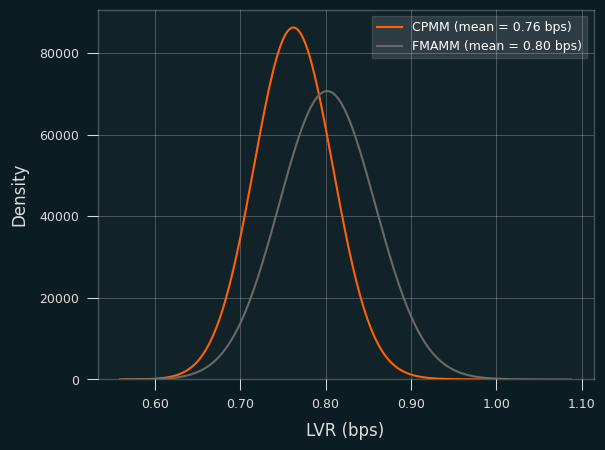

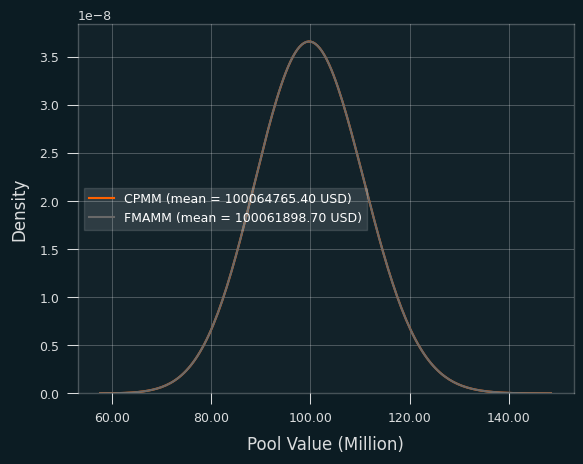

In [11]:
# Scenario 4: 5% daily volatility, L1 with congestion
p_init = 2_500.0
l_init = 1_000_000.0
tx_cost = 30

daily_std = 0.05
block_time = 12  # 12 for Mainnet, 5 for Gnosis, 2 for L2s
blocks_per_day = 24 * 60 * 60 / block_time
paths = 1_000
days = 7

results = run_simulations(
    p_init, l_init, tx_cost, daily_std, blocks_per_day, paths, days
)

bw_adjust = 5
means = np.mean(results, 1)

ax = sns.kdeplot(
    data=results[0, :],
    bw_adjust=bw_adjust,
    label=f"CPMM (mean = {means[0] * 10**4:.2f} bps)",
)
ax = sns.kdeplot(
    data=results[1, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM (mean = {means[1] * 10**4:.2f} bps)",
)

ax.set(xlabel="LVR (bps)", ylabel="Density")
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels([f"{tick * 10000:.2f}" for tick in ticks_loc])

plt.legend()
plt.show()

ax = sns.kdeplot(
    data=results[2, :],
    bw_adjust=bw_adjust,
    label=f"CPMM (mean = {means[2]:.2f} USD)",
)
ax = sns.kdeplot(
    data=results[3, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM (mean = {means[3]:.2f} USD)",
)

ax.set(xlabel="Pool Value (Million)", ylabel="Density")
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels([f"{tick / 10**6:.2f}" for tick in ticks_loc])

plt.legend()
plt.show()

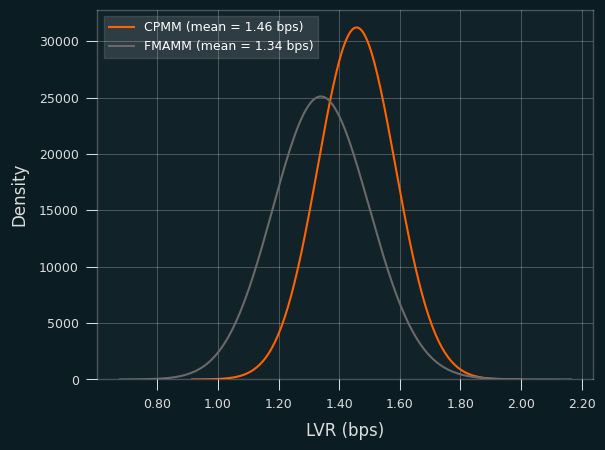

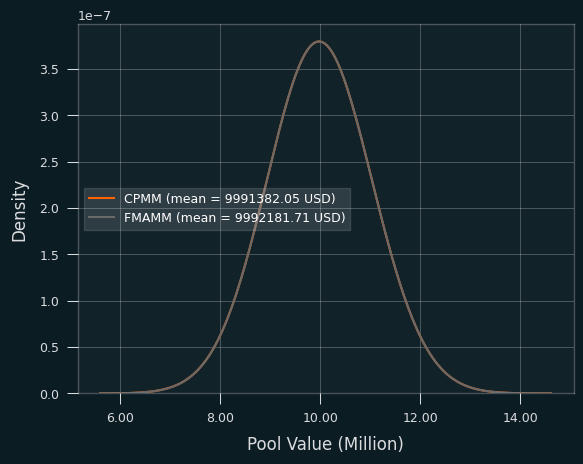

In [13]:
# Scenario 5: 5% daily volatility, L1 with congestion, with smaller liquidity
p_init = 2_500.0
l_init = 1_00_000.0
tx_cost = 30

daily_std = 0.05
block_time = 12  # 12 for Mainnet, 5 for Gnosis, 2 for L2s
blocks_per_day = 24 * 60 * 60 / block_time
paths = 1_000
days = 7

results = run_simulations(
    p_init, l_init, tx_cost, daily_std, blocks_per_day, paths, days
)

bw_adjust = 5
means = np.mean(results, 1)

ax = sns.kdeplot(
    data=results[0, :],
    bw_adjust=bw_adjust,
    label=f"CPMM (mean = {means[0] * 10**4:.2f} bps)",
)
ax = sns.kdeplot(
    data=results[1, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM (mean = {means[1] * 10**4:.2f} bps)",
)

ax.set(xlabel="LVR (bps)", ylabel="Density")
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels([f"{tick * 10000:.2f}" for tick in ticks_loc])

plt.legend()
plt.show()

ax = sns.kdeplot(
    data=results[2, :],
    bw_adjust=bw_adjust,
    label=f"CPMM (mean = {means[2]:.2f} USD)",
)
ax = sns.kdeplot(
    data=results[3, :],
    bw_adjust=bw_adjust,
    label=f"FMAMM (mean = {means[3]:.2f} USD)",
)

ax.set(xlabel="Pool Value (Million)", ylabel="Density")
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels([f"{tick / 10**6:.2f}" for tick in ticks_loc])

plt.legend()
plt.show()